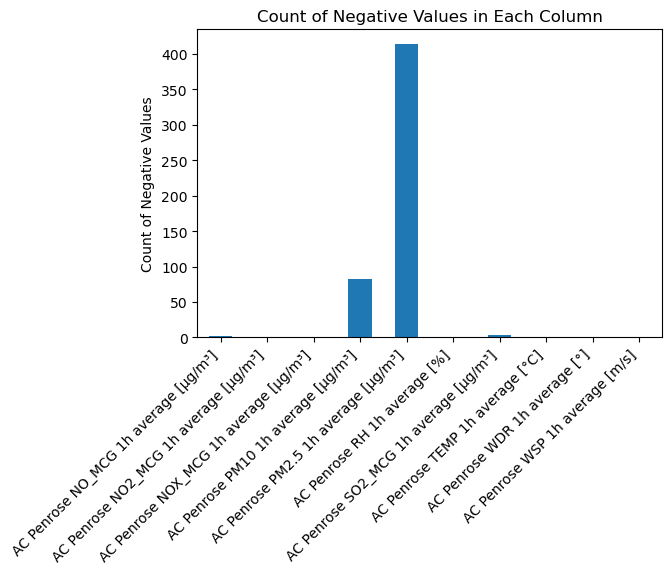

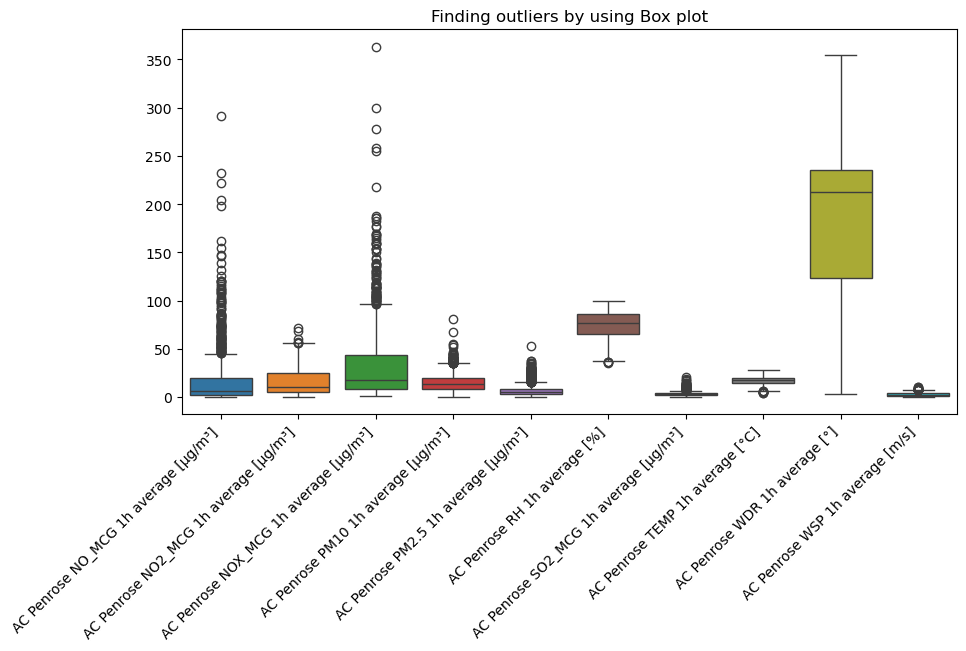

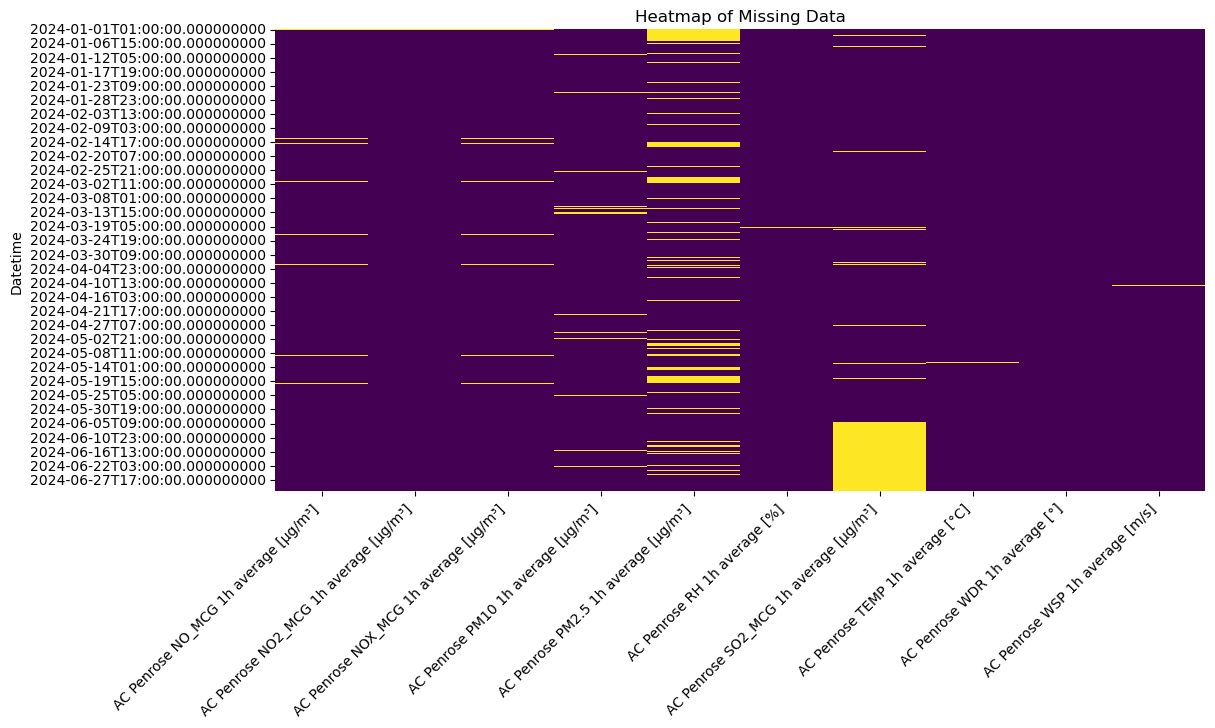

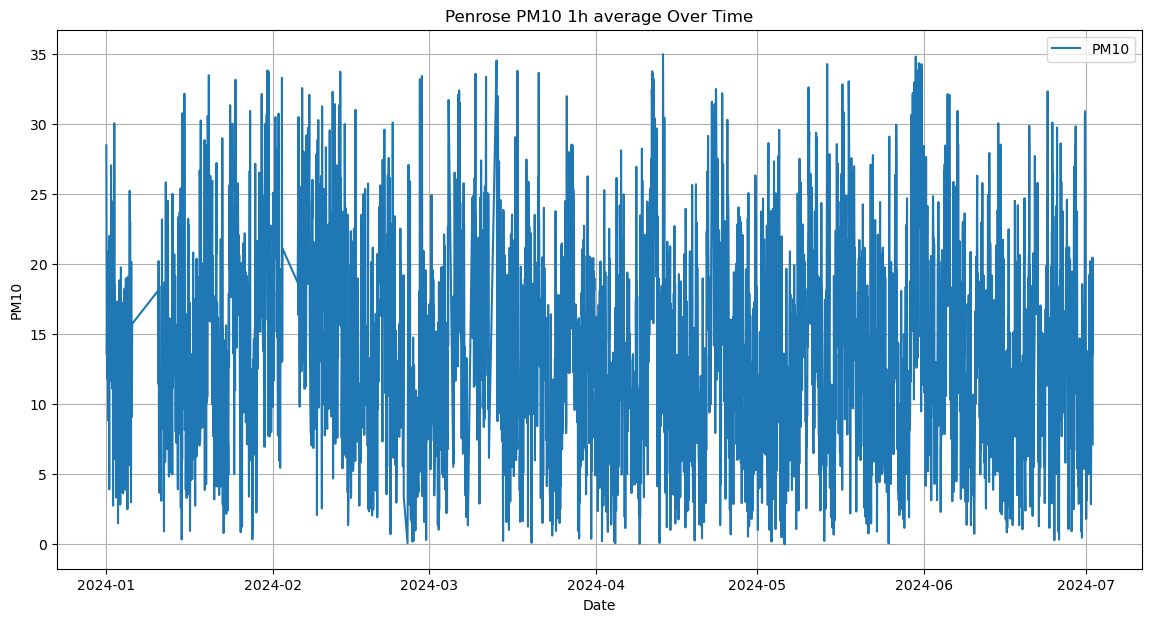

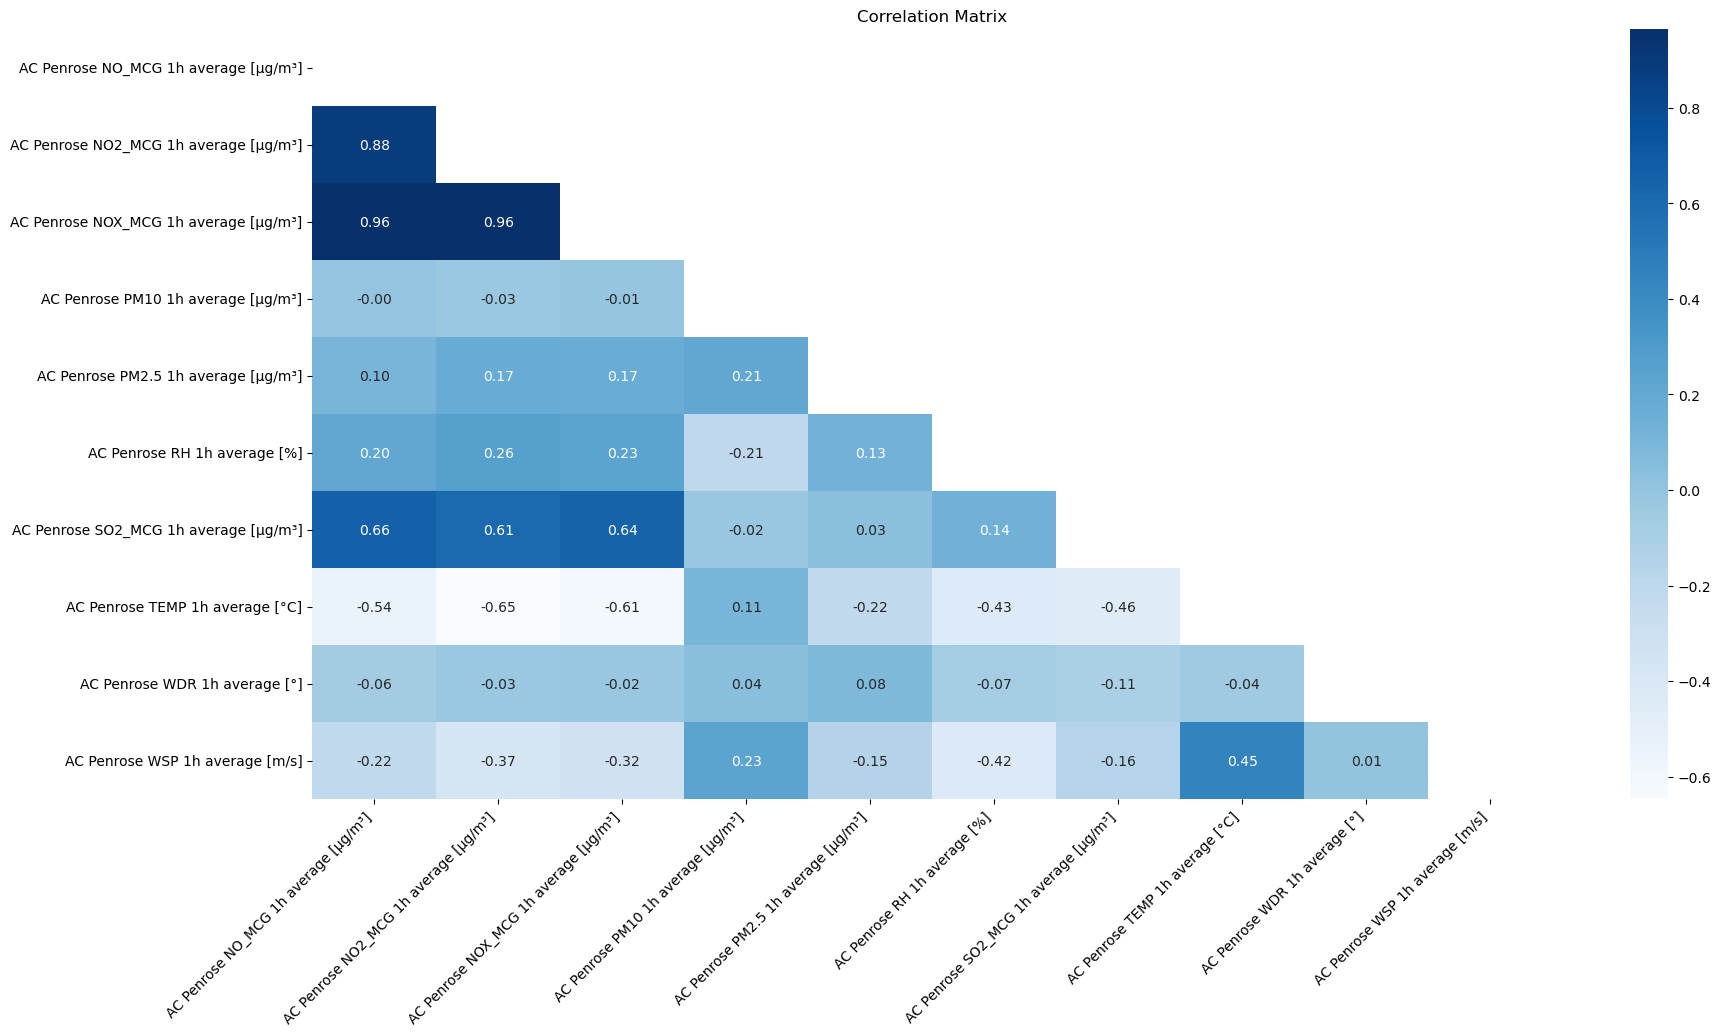

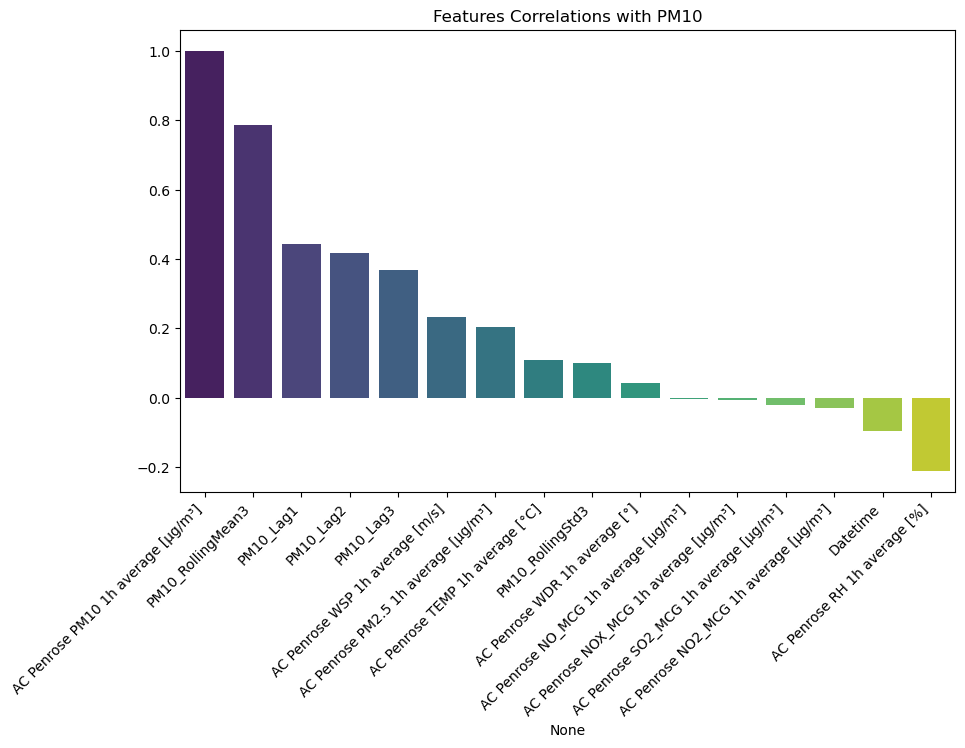

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
import warnings

warnings.filterwarnings('ignore')

def process_air_quality_data(input_csv, output_csv):
    # Read the CSV file with specific encoding and delimiter
    data = pd.read_csv(input_csv, encoding='latin1')

    # Merge date and time columns together to create a 'Datetime' column
    data["Datetime"] = pd.to_datetime(data["Date"] + " " + data["Time"], format='%d/%m/%Y %H:%M', errors='coerce')

    # Drop the original 'Date' and 'Time' columns
    data = data.drop(columns=["Date", "Time"])

    # Drop duplicates based on the 'Datetime' column
    data = data.drop_duplicates(subset=["Datetime"])

    # Create a complete datetime range based on the minimum and maximum datetime values in the data
    full_datetime_range = pd.date_range(start=data["Datetime"].min(), end=data["Datetime"].max(), freq='H')

    # Reindex the DataFrame with the complete datetime range to identify missing datetimes
    data = data.set_index("Datetime").reindex(full_datetime_range)

    # Rename the index to 'Datetime'
    data.index.name = 'Datetime'

    # Interpolate missing values using time interpolation
    data.interpolate(method='time', inplace=True)

    # Count negative values present in dataset
    negative_counts = ((data < 0) & (data.notna()) & (data != 0)).sum()

    # Plotting the negative counts
    plt.figure(figsize=(6, 4))
    negative_counts.plot(kind='bar')
    plt.title('Count of Negative Values in Each Column')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count of Negative Values')
    plt.show()

    # Replace negative values with null values
    data[data < 0] = np.nan

    # Finding outliers using Box plot
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=data)
    plt.title('Finding outliers by using Box plot')
    plt.xticks(rotation=45, ha="right")
    plt.show()

    # Function to remove outliers using IQR method
    def remove_outliers_iqr(data, k=1.5):
        numeric_df = data.select_dtypes(include=np.number)
        Q1 = numeric_df.quantile(0.25)
        Q3 = numeric_df.quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR

        # Replace outliers with NaNs
        data_cleaned = data.copy()
        for col in numeric_df.columns:
            outlier_mask = (data_cleaned[col] < lower_bound[col]) | (data_cleaned[col] > upper_bound[col])
            data_cleaned.loc[outlier_mask, col] = np.nan

        return data_cleaned

    # Remove outliers
    df_cleaned = remove_outliers_iqr(data)

    # Plot the heatmap of missing data
    plt.figure(figsize=(12, 6))
    sns.heatmap(df_cleaned.isnull(), cbar=False, cmap='viridis')
    plt.xticks(ticks=np.arange(len(data.columns)) + 0.5, labels=data.columns, rotation=45, ha='right')
    plt.title('Heatmap of Missing Data')
    plt.show()

    # Ensure datetime is sorted (though it should already be in order with hourly data)
    df_cleaned = df_cleaned.sort_index()

    # Reset index to make 'Datetime' a column
    df_cleaned = df_cleaned.reset_index()

    # Separate datetime for indexing
    datetime_series = df_cleaned['Datetime']

    # Drop 'Datetime' column for imputation
    df_cleaned = df_cleaned.drop(columns=['Datetime'])

    # Impute missing values in numerical features using KNNImputer
    imputer = KNNImputer(n_neighbors=2)
    df_imputed_values = imputer.fit_transform(df_cleaned)

    # Convert the imputed values back to a DataFrame
    df_imputed = pd.DataFrame(df_imputed_values, columns=df_cleaned.columns)

    # Add datetime series back to the imputed DataFrame
    df_imputed['Datetime'] = datetime_series

    # Ensure the 'Datetime' column is in the correct position
    df_imputed = df_imputed.set_index('Datetime')

    # Plot the time series data
    plt.figure(figsize=(14, 7))
    plt.plot(df_imputed.index, df_imputed['AC Penrose PM10 1h average [µg/m³]'], label='PM10')
    plt.title('Penrose PM10 1h average Over Time')
    plt.xlabel('Date')
    plt.ylabel('PM10')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Compute the correlation matrix
    corr = df_imputed.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    plt.figure(figsize=(20, 10))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap="Blues", annot=True, fmt=".2f")
    plt.title('Correlation Matrix')
    plt.xticks(rotation=45, ha="right")
    plt.show()

    # Reset index
    df_imputed.reset_index("Datetime", inplace=True)

    # Create lag features
    df_imputed['PM10_Lag1'] = df_imputed['AC Penrose PM10 1h average [µg/m³]'].shift(1)
    df_imputed['PM10_Lag2'] = df_imputed['AC Penrose PM10 1h average [µg/m³]'].shift(2)
    df_imputed['PM10_Lag3'] = df_imputed['AC Penrose PM10 1h average [µg/m³]'].shift(3)

    # Create rolling statistics
    df_imputed['PM10_RollingMean3'] = df_imputed['AC Penrose PM10 1h average [µg/m³]'].rolling(window=3).mean()
    df_imputed['PM10_RollingStd3'] = df_imputed['AC Penrose PM10 1h average [µg/m³]'].rolling(window=3).std()

    # Drop rows with NaN values resulting from lag/rolling operations
    df = df_imputed.dropna()

    # Calculate correlation matrix
    correlation_matrix = df.corr()
    # Extract Features Correlations with Customer Churn
    satisfaction_correlations = correlation_matrix["AC Penrose PM10 1h average [µg/m³]"].sort_values(ascending=False)
    
    # Plot the correlations
    plt.figure(figsize=(10, 6))
    sns.barplot(x=satisfaction_correlations.index, y=satisfaction_correlations.values, palette="viridis")
    plt.xticks(rotation=45, ha="right")
    plt.title("Features Correlations with PM10")
    plt.show()

    # Drop the 'Date' column as it's not used in the model
    X = df.drop(columns=['Datetime', 'AC Penrose PM10 1h average [µg/m³]'])
    y = df['AC Penrose PM10 1h average [µg/m³]']

    # Fit a Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    # Get feature importances
    importances = model.feature_importances_

    # Create a DataFrame for visualization
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

    # Sort features by importance
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    # Select top 5 features
    top_features = feature_importances.head(5)['Feature'].tolist()
    data_selected = df[top_features + ['AC Penrose PM10 1h average [µg/m³]', 'Datetime']]

    # Save cleaned file
    data_selected.to_csv(output_csv, encoding='latin1')

# Example usage
process_air_quality_data("CSV_File_1718229021.csv", "PM10_1hr_TopFeatures.csv")
